In [2]:
# following this tutorial: https://www.projectpro.io/article/how-to-build-arima-model-in-python/544

# import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [8]:
# load dataset
excel_file = pd.read_excel("/Users/sahiti/Desktop/stock0.xlsx")
excel_file.to_csv ("stock0.csv", index = None, header=True)
df_subset = pd.read_csv("stock0.csv")
print(df_subset)

# using subset of data to create model for right now, all the data is too much
# df_subset = df.copy().loc[:28649]
# df_subset

      stock_id  date_id  seconds_in_bucket  imbalance_size  \
0            0        0                  0      3180602.69   
1            0        0                 10      1299772.70   
2            0        0                 20      1299772.70   
3            0        0                 30      1299772.70   
4            0        0                 40      1218204.43   
...        ...      ...                ...             ...   
5401         0       98                110      1532025.15   
5402         0       98                120      1532025.15   
5403         0       98                130      1532025.15   
5404         0       98                140      1532025.15   
5405         0       98                150      1532025.15   

      imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                           1         0.999812   13380276.64        NaN   
1                           1         1.000026   15261106.63        NaN   
2                           1 

In [11]:
df_subset["price_spread"] = df_subset["ask_price"] - df_subset["bid_price"]

# creating new imbalance size difference column as differencing 'd' for model
df_subset["price_spread_difference"] = df_subset['imbalance_size'].diff(periods=1)

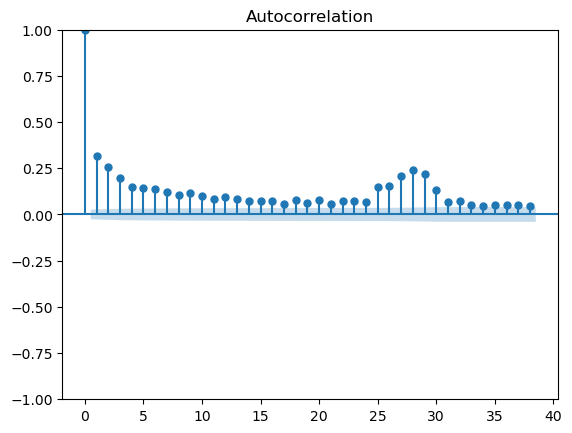

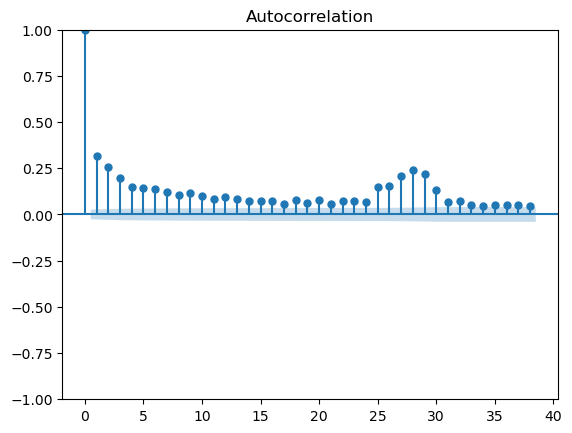

In [12]:
plot_acf(df_subset["price_spread"])

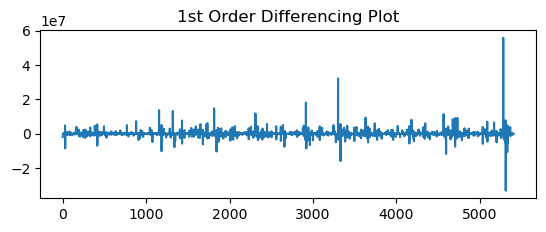

In [13]:
# From the autocorrelation graph, we can decide if more differencing is needed. 
# If collectively the autocorrelations, or the data point of each lag (in the horizontal axis), are positive for several consecutive lags, more differencing might be needed. 
# Conversely, if more data points are negative, the series is over-differenced.

f = plt.figure()
ax1 = f.add_subplot(212)
ax1.set_title("1st Order Differencing Plot")
ax1.plot(df_subset["price_spread_difference"])

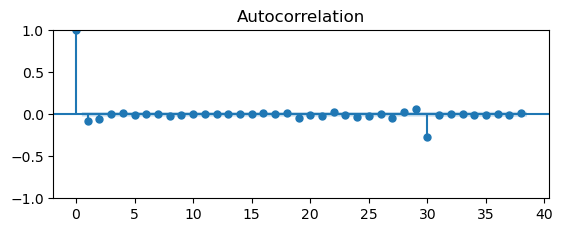

In [14]:
f2 = plt.figure()
ax2 = f2.add_subplot(212)
plot_acf(df_subset["price_spread_difference"].dropna(), ax = ax2)
plt.show()

In [15]:
# mathematical: adf test - if p is less than 0.05 the data is stationary, otherwise increase differencing by 1
result = adfuller(df_subset["price_spread_difference"].dropna())
print("p-value:", result[1])

# first order differncing is small enough

p-value: 2.219495489598931e-30


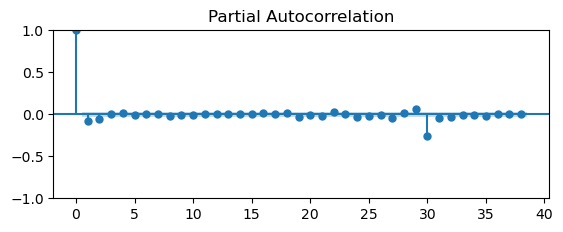

In [16]:
# computing 'p' or the number of lagged (or past) observations to consider for autoregression
# based on the most significant lag in the partial autocorrelation plot

f = plt.figure()
ax2 = f.add_subplot(212)
plot_pacf(df_subset["price_spread_difference"].dropna(), ax = ax2)
plt.show()

# most significant is 1

In [17]:
# determining 'q' or the size of the moving average window
# Looking at the number of lags crossing the threshold, we can determine how much of the past would be significant enough to consider for the future.

# im estimating q = 2 will be good idrk

# final python ARIMA model = ARIMA(p = 1, d = 1, q = 2)

In [18]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df_subset["price_spread"], order = (1, 1, 2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:           price_spread   No. Observations:                 5406
Model:                 ARIMA(1, 1, 2)   Log Likelihood               39863.518
Date:                Mon, 27 Nov 2023   AIC                         -79719.035
Time:                        17:55:26   BIC                         -79692.655
Sample:                             0   HQIC                        -79709.826
                               - 5406                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6476   1.33e-20  -4.87e+19      0.000      -0.648      -0.648
ma.L1         -0.0339   6.65e-20   -5.1e+17      0.000      -0.034      -0.034
ma.L2         -0.4641   7.43e-20  -6.24e+18      0.0

/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


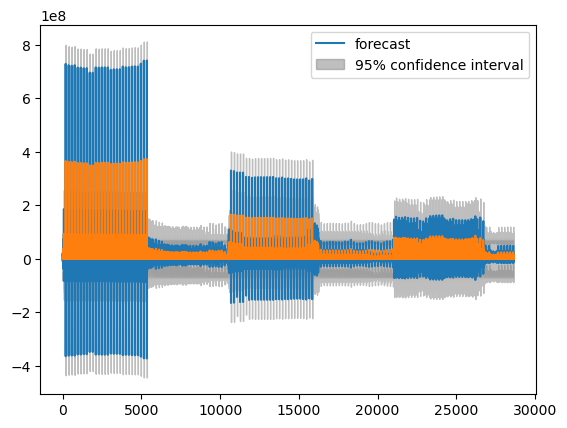

In [26]:
# plotting ARIMA forecast results
from statsmodels.graphics.tsaplots import plot_predict

res = ARIMA(df_subset["imbalance_size"], order=(0,2,0)).fit()
fig, ax = plt.subplots()
plot_predict(res, ax=ax)
ax = df_subset["imbalance_size"].plot(ax=ax)
plt.show()

# not perfectly aligned but in the right direction?? need to figure out how to plot better

In [39]:
import statsmodels as sm
model = sm.tsa.arima.model.ARIMA(df_subset.loc[0:2000, "price_spread"], order=(1, 1, 2))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:           price_spread   No. Observations:                 2001
Model:                 ARIMA(1, 1, 2)   Log Likelihood               14459.013
Date:                Mon, 27 Nov 2023   AIC                         -28910.026
Time:                        18:13:54   BIC                         -28887.622
Sample:                             0   HQIC                        -28901.799
                               - 2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3195   7.39e-20  -4.32e+18      0.000      -0.320      -0.320
ma.L1         -0.3168   2.03e-19  -1.56e+18      0.000      -0.317      -0.317
ma.L2         -0.3038   1.73e-19  -1.76e+18      0.0

/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
X = df_subset["price_spread"]
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)].reset_index(drop=True)
history = [x for x in train]
predictions = list()

for t in range(len(test)):
	model = sm.tsa.arima.model.ARIMA(history, order=(1,1,2))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print(t, len(test), 'predicted=%f, expected=%f' % (yhat, obs))

/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0 271 predicted=0.000212, expected=0.000443


/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1 271 predicted=0.000299, expected=0.000111


/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 271 predicted=0.000214, expected=0.000222
3 271 predicted=0.000239, expected=0.000222


/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4 271 predicted=0.000222, expected=0.000111


/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5 271 predicted=0.000190, expected=0.000111


/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6 271 predicted=0.000166, expected=0.000110


/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7 271 predicted=0.000150, expected=0.000222


/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8 271 predicted=0.000177, expected=0.000110
9 271 predicted=0.000148, expected=0.000443


/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10 271 predicted=0.000259, expected=0.000222


KeyboardInterrupt: 

In [35]:
mape = np.mean(np.abs(y_pred - y_true)/ np.abs(y_true)) # mean absolute percentage error
mae = np.mean(np.abs(y_pred - y_true)) # mean absolute error
mpe = np.mean((y_pred - y_true)/ (y_true)) # mean percentage error
rmse = np.mean((y_pred - y_true) ** 2) ** 0.5 
corr = np.corrcoef(y_pred, y_true) [0, 1] # correlation coefficient

print("mape:", mape, ",", "mae: ", mae, ",", "mpe: ", mpe, ",", "rmse: ", rmse, ",", "corr: ", corr)

mape: nan , mae:  nan , mpe:  nan , rmse:  nan , corr:  nan
